In [1]:
import tensorflow as tf
import numpy as np
import sys
tf.reset_default_graph()
from os import path
tf.logging.set_verbosity(tf.logging.WARN)
import time
import os
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display, HTML

In [2]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
# Parameters
pi = 3.14159265359
N_d = 5000
N_max = 50
I_max = 10
x_f = np.zeros([1,3])
C = np.array([i for i in range(I_max)])
iterations = 50

In [4]:
data = np.empty(I_max, dtype=object)

In [5]:
# Data Points_Sphere
for i in range(I_max):
    data[i] = np.empty([N_d, 3], dtype=float)
    for j in range(5000):
        phi = random.uniform(0, 2*pi)
        costheta = random.uniform(-1,1)
        u = random.uniform(0,1)
        theta = np.arccos(costheta)
        r = u**(1./3)*(i+1)
        data[i][j][0] = r * np.sin(theta) * np.cos(phi)
        data[i][j][1] = r * np.sin(theta) * np.sin(phi)
        data[i][j][2] = r * np.cos(theta)

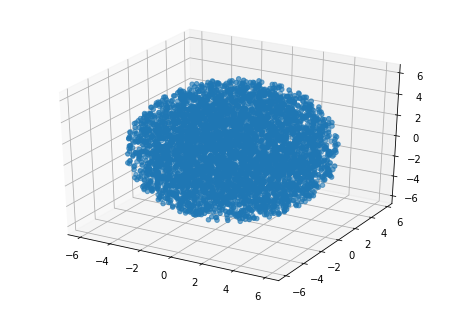

In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[5][:,0], data[5][:,1], data[5][:,2])
plt.show()

In [7]:
def multilayer_perceptron(x, weights, biases):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [8]:
model_name= 'Robot_cotroller'
model_dir = 'model/' + model_name
save_dir = os.path.join(model_dir, "save/")
log_dir = os.path.join(model_dir, "log")

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [9]:
init = tf.placeholder('float', [1, 3], name = 'initial_point' )
target = tf.placeholder('float', [1, 3], name='final_point')
error = tf.subtract(target, init)
lambda_k = tf.placeholder('float', [1, 3], name='lambda_k')
J = tf.constant(1.0 , shape=[3, 3])
R = tf.constant(1.0 , shape=[3,3])


with tf.variable_scope('critic_network'):
    weights = {
        'h1': tf.Variable(tf.random_normal([3, 5])),
        'out': tf.Variable(tf.random_normal([5, 3]))
    }

    biases = {
        'b1': tf.Variable(tf.random_normal([5])),
        'out': tf.Variable(tf.random_normal([3]))
    }

    lambda_k_1 = multilayer_perceptron(error, weights, biases)
    cost = tf.squared_difference(lambda_k, lambda_k_1)


    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
    
with tf.variable_scope('control'): 
#     u_opt = tf.matmul(tf.matmul(tf.matrix_inverse(R), tf.matrix_transpose(J)), tf.matrix_transpose(lambda_k_1))
      u_opt = tf.matrix_transpose(lambda_k_1)
    

with tf.variable_scope('Robot'):
    init_update = tf.matmul(J, u_opt)    

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(tf.global_variables_initializer())                          # For initializing all the variables
saver = tf.train.Saver()                                             # For Saving the model
summary_writer = tf.summary.FileWriter(log_dir, sess.graph) 

In [11]:
init_update.get_shape().as_list()

[3, 1]

In [12]:
show_graph(tf.get_default_graph().as_graph_def())

In [13]:
initial_point = np.zeros([1,3])
target_point = data[0][random.randint(1, 5000)].reshape([1,3])
i = sess.run(init, feed_dict={init:initial_point, target:target_point})
l = sess.run(lambda_k_1, feed_dict={init:i, target:target_point})
l_up = (target_point-i) + l
for i in range(iterations):
    _, loss, next_inp = sess.run([optimizer, cost, init_update], feed_dict={init:initial_point, target:target_point, lambda_k:l_up})
    initial_point += np.transpose(next_inp)
    print('loss: {:>6.3f} '.format(loss)) 

loss: -3.095 
loss: -2.846 
loss: -6.123 
loss: -2.929 
loss: -5.767 
loss: -2.924 
loss: -5.775 
loss: -2.927 
loss: -5.748 
loss: -2.929 
loss: -5.725 
loss: -2.931 
loss: -5.701 
loss: -2.934 
loss: -5.677 
loss: -2.936 
loss: -5.654 
loss: -2.938 
loss: -5.630 
loss: -2.940 
loss: -5.606 
loss: -2.943 
loss: -5.583 
loss: -2.945 
loss: -5.559 
loss: -2.947 
loss: -5.536 
loss: -2.949 
loss: -5.513 
loss: -2.952 
loss: -5.489 
loss: -2.954 
loss: -5.466 
loss: -2.956 
loss: -5.443 
loss: -2.958 
loss: -5.420 
loss: -2.960 
loss: -5.397 
loss: -2.963 
loss: -5.374 
loss: -2.965 
loss: -5.352 
loss: -2.967 
loss: -5.329 
loss: -2.969 
loss: -5.306 
loss: -2.971 
loss: -5.284 
loss: -2.973 
